<hr style="border:2px solid #FEC60D"> </hr>
<center><h1 style="color:#173F8A;"> Álgebra Lineal Aplicada para Ciencia de Datos</h1></center> 
<center><h1 style="color:#173F8A;"> MDS3120-B4-2025</h1></center>
<hr style="border:2px solid #FEC60D"> </hr>
<h3 style="color:#0176DE;text-align:right;"> Profesores: &nbsp;Manuel A. Sánchez<br>Carlos Sing-Long<br></h3>

<h3 style="color:#03122E;text-align:right;"> 
    Magister en Ciencia de Datos - MDS <br> 
    Instituto de Ingeniería Matemática y Computacional - IMC<br>  
    Pontificia Universidad Católica de Chile <br>   
</h3>

<hr style="border:2px solid #03122E"> </hr>
<center><h1 style="color:#173F8A;"> Clase 1 sincrónica: Clustering y Clasificación</h1></center> 
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC:
Primaria: 
celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 
Secundaria
gris oscuro: #707070
-->

**Referencia bibliográfica**
- Data Driven Science and Engineering. Brunton and Kutz. Capítulo 5.

## Tabla de Contenidos
1. [**Clustering y Clasificacion**](#Clustering-y-Clasificacion)
2. [**K-means**](#Algoritmo-k-means)
3. [**Dendrogramas**](#Dendrograma:-Unsupervised-Hierarchical-Clustering)
4. [**Discriminantes lineales LDA**](#Aprendizaje-Supervisado-y-Discriminantes-Lineales)
5. [**Árboles de decición**](#Arboles-de-decision)


In [2]:
import numpy as np
import scipy.linalg as lg
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import pandas as pd
import sklearn as skl
# !pip install threadpoolctl==3.2.0
from IPython.display import display, HTML
display(HTML("""<style>.output {display: flex;align-items: center;text-align: center;}</style>"""))
rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [6, 6]

<hr style="border:2px solid #03122E"> </hr>

## Clustering y Clasificacion

Aprendizaje de máquina **supervisado** vs. Aprendizaje de máquina **no supervisado**.

El algoritmo de k-means es un ejemplo de aprendizaje no supervisado.

El algoritmo de k-means asume que dado un conjunto de datos vectoriales el objetivo es particionar las observaciones en $k$ clusters o grupos.

Si bien el número de observación y la dimensión del sistema son conocidas, el número de particiones $k$ es generalmente desconocido y debe ser también determinado.

El algoritmo de $k$-means es iterativo, primero asume valores iniciales para el representante de cada cluster y luego los actualiza por algoritmo hasta converger.

El objetivo de $k$ means puede formularse formalmente en términos de un problema de optimización. 

$$
\text{argmin}_{\mathbf{\mu}_j} \sum_{j=1}^{k} \sum_{\mathbf{x}_n\in \mathcal D_j'} \|\mathbf{x}_n - \mathbf{\mu}_j\|^2
$$

donde $\mathbf{\mu}_j$ denota el promedio del cluster $j$-\'esimo y $\mathcal D_j'$ denota el subdominio de datos asociados a ese cluster.


<hr style="border:2px solid #03122E"> </hr>

## Algoritmo k-means

In [3]:
# Training and testing set sizes
n1 = 100 # Train
n2 = 50  # Test

# Random ellipse 1 centered at (0,0)
x = np.random.randn(n1+n2)
y = 0.5*np.random.randn(n1+n2)

# Random ellipse 2 centered at (1,-2)
x2 = np.random.randn(n1+n2) + 1
y2 = 0.2*np.random.randn(n1+n2) - 2

# Rotate ellipse 2 by theta
theta = np.pi/4
A = np.zeros((2,2))
A[0,0] = np.cos(theta)
A[0,1] = -np.sin(theta)
A[1,0] = np.sin(theta)
A[1,1] = np.cos(theta)

x3 = A[0,0]*x2 + A[0,1]*y2
y3 = A[1,0]*x2 + A[1,1]*y2

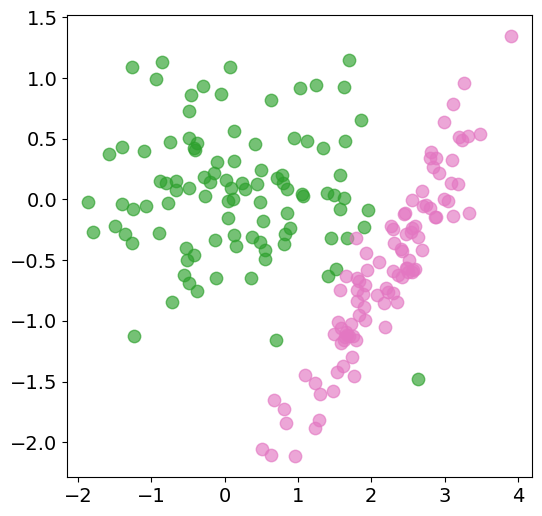

In [3]:
plt.figure()
plt.scatter(x[:n1],y[:n1],color='C02', alpha=0.65, s=80);
plt.scatter(x3[:n1],y3[:n1],color='C06', alpha=0.65, s=80);
plt.show()

In [4]:
# Training set: first 200 of 240 points
X1 = np.column_stack((x3[:n1],y3[:n1]))
X2 = np.column_stack((x[:n1],y[:n1]))

Y = np.concatenate((X1,X2))
Z = np.column_stack((np.ones(n1),2*np.ones(n1)))

# Test set: remaining 40 points
x1test = np.column_stack((x3[n1:],y3[n1:]))
x2test = np.column_stack((x[n1:],y[n1:]))


In [27]:
g1 = np.array([-1, 0]) # Initial guess
g2 = np.array([1, 0])
def plot_cluster_evol(g1input,g2input):
    g1=g1input.copy(); g2=g2input.copy()
    fig,axs = plt.subplots(2,2, figsize=(10,8)); axs = axs.reshape(-1)
    for j in range(8):
        class1 = np.zeros((1,2)); class2 = np.zeros((1,2))
        for jj in range(Y.shape[0]):
            d1 = np.linalg.norm(g1-Y[jj,:],ord=2)
            d2 = np.linalg.norm(g2-Y[jj,:],ord=2)
            if d1<d2:
                class1 = np.append(class1,Y[jj,:].reshape((1,2)),axis=0)
            else:
                class2 = np.append(class2,Y[jj,:].reshape((1,2)),axis=0)
        class1 = np.delete(class1, (0), axis=0) # remove zeros used to initialize
        class2 = np.delete(class2, (0), axis=0)
        if j <4:
            axs[j].scatter(class1[:,0],class1[:,1], s=80, color='C02', alpha=0.65)
            axs[j].scatter(class2[:,0], class2[:,1],s=80, color='C06', alpha=0.65)
            axs[j].plot(g1[0],g1[1],'k*',ms=30)
            axs[j].plot(g2[0],g2[1],'k*',ms=30) 
        g1 = np.array([np.mean(class1[:,0]),np.mean(class1[:,1])])
        g2 = np.array([np.mean(class2[:,0]),np.mean(class2[:,1])])
    plt.show()
    return g1, g2

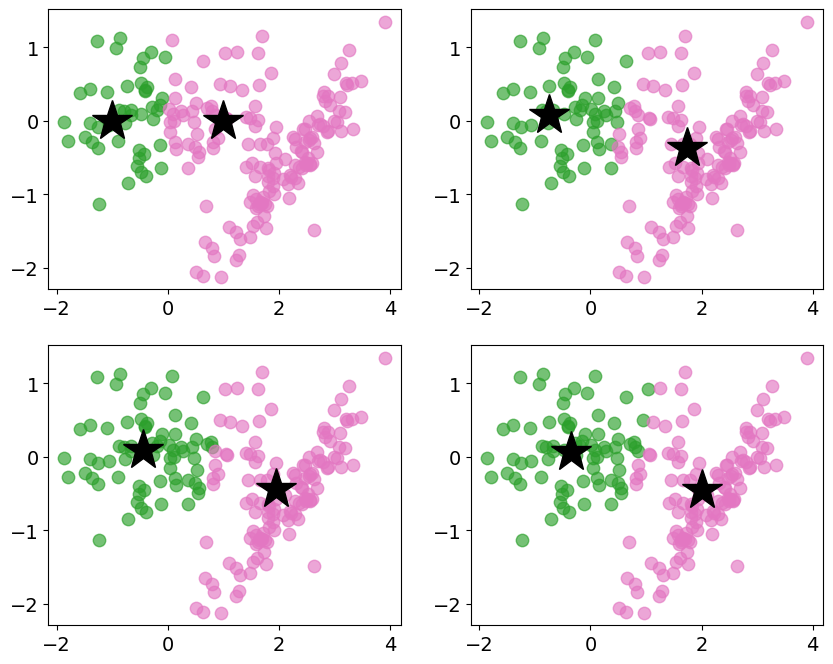

In [28]:
g1new, g2new = plot_cluster_evol(g1,g2)

**Ilustración de la iteración de $k$-means.** Los puntos iniciales aparecen en el primer gráfico y luego las iteraciones que siguen.

In [33]:
# kmeans code
kmeans = KMeans(n_clusters=2, random_state=0).fit(Y)
c = kmeans.cluster_centers_
ind = kmeans.labels_

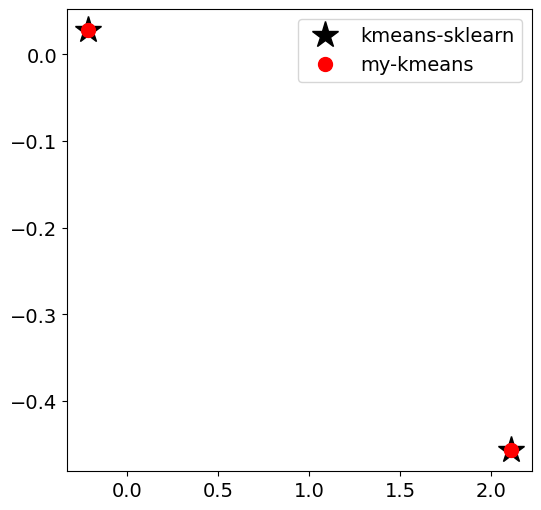

In [36]:
# plot
plt.plot(c[:,0],c[:,1],'k*',ms=20, label='kmeans-sklearn')
plt.plot([g1new[0],g2new[0]],[g1new[1],g2new[1]],'ro',ms=10, label='my-kmeans')
plt.legend()
plt.show()

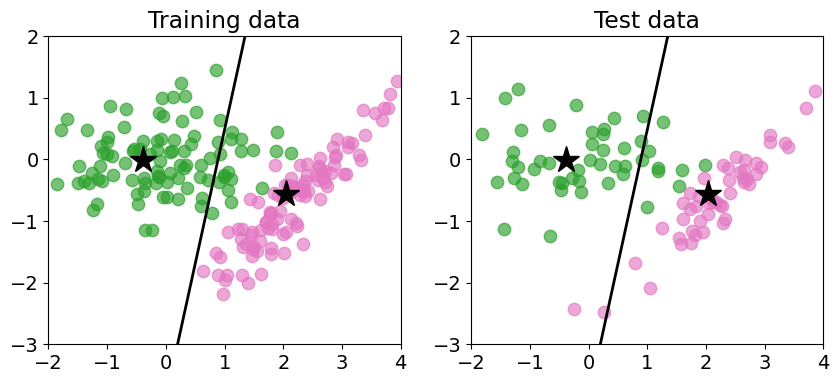

In [285]:
midx = (c[0,0]+c[1,0])/2
midy = (c[0,1]+c[1,1])/2
slope = (c[1,1]-c[0,1])/(c[1,0]-c[0,0]) # rise/run
b = midy+(1/slope)*midx
xsep = np.arange(-1,2,0.1)
ysep = -(1/slope)*xsep+b

fig,axs = plt.subplots(1,2, figsize=(10,4))
axs[0].scatter(x[:n1], y[:n1], alpha=0.65, color='C02', s=80)
axs[0].scatter(x3[:n1], y3[:n1], alpha=0.65, color='C06', s=80)
axs[0].plot(xsep,ysep,c='k',linewidth=2)
axs[0].set_xlim(-2,4)
axs[0].set_ylim(-3,2)
axs[0].set_title('Training data')
# kmeans result
axs[0].plot(c[0,0],c[0,1],'k*',ms=20)
axs[0].plot(c[1,0],c[1,1],'k*',ms=20)
# error on test data
axs[1].scatter(x[n1:], y[n1:], alpha=0.65, color='C02', s=80)
axs[1].scatter(x3[n1:], y3[n1:], alpha=0.65, color='C06', s=80)
axs[1].plot(xsep,ysep,c='k',linewidth=2)
axs[1].set_xlim(-2,4)
axs[1].set_ylim(-3,2)
axs[1].set_title('Test data')

# kmeans result
axs[1].plot(c[0,0],c[0,1],'k*',ms=20)
axs[1].plot(c[1,0],c[1,1],'k*',ms=20)
plt.show()

**¿Cómo calculamos la línea de decisión?**

Si $z_1$ y $z_2$ son los representantes, con $z_1= (x_1,y_1)$, $z_2=(x_2,y_2)$. Entonces la linea de decisión

$$
L: y = mx - b
$$
donde 
$$
m = \frac{y_2-y_1}{x_2-x_1}, \quad b = \frac{y_1+y_2}{2} + \frac{1}{m}\left(\frac{x_1+x_2}{2}\right)
$$


En las figuras observamos los resultados del algoritmo de $k$-means. Estos muestran que la línea de decisión separa los datos en dos clusters. Los puntos verdes y rosa denotan las etiquetas verdaderas de los datos, mostrando que la línea de $k$-means no extrae correctamente todas las etiquetas. De hecho, un algoritmo supervisado es más competente para extraer los resultados verdaderos. Sin embargo, el algoritmo sí obtiene una mayoría de los datos etiquetados correctamente.

El exito de $k$-mean se basa en dos factores:
- No es necesaria la supervisión.
- Es un algoritmo heurístico rápido.

El ejemplo muestra que el método no es muy preciso, pero este es usualmente el caso de métodos no supervisados, ya que tienen conocimiento limitado de los datos. Validación cruzada, como por ejemplo $k$-fold cross validation puede ayudar a mejorar el modelo y hacer del aprendizaje no supervisado más preciso, pero en general será menos preciso que un algoritmo supervisado que tiene los datos etiquetados.



<hr style="border:2px solid #03122E"> </hr>

## Dendrograma: Unsupervised Hierarchical Clustering

**Aglomerativo**: Cada punto de los datos $\mathbf{x}_j$ es inicialmente su propio cluster. Los datos se fusionan en pares a medida que se crea una jerarquía de clústeres. La fusión de datos eventualmente se detiene una vez que todos los datos se han fusionado en un único superclúster. Este es el enfoque de abajo hacia arriba en la agrupación jerárquica.


**Divisivo**: En este caso, todas las observaciones $\mathbf{x}_j$ son inicialmente parte de un único clúster gigante. Luego, los datos se dividen recursivamente en clústeres cada vez más pequeños. La división continúa hasta que el algoritmo se detiene según un objetivo especificado por el usuario. El método divisivo puede dividir los datos hasta que cada punto de datos sea su propio nodo

Nos centraremos en algoritmos **Clustering jerárquicos Aglomerativos**.


Construir el **dendrograma** procede como una simple estructura algorítmica basada sobre el cálculo de la distancia entre los puntos de datos.
Si bien típicamente usamos la distancia Euclideana, hay un número importante de métricas de distancia que se podrían considerar para distintos tipos de datos. 
Algunas de estas distancias tipicas estan dadas por las siguientes:
\begin{align*}
\text{distancia Euclideana } & \|\mathbf{x}_j-\mathbf{x}_{k}\|_2, \\
\text{distancia Euclideana cuadrada } & \|\mathbf{x}_j-\mathbf{x}_{k}\|_2^2, \\
\text{distancia Manhattan } & \|\mathbf{x}_j-\mathbf{x}_{k}\|_1, \\
\text{distancia del máximo } & \|\mathbf{x}_j-\mathbf{x}_{k}\|_{\infty}, \\
\text{distancia de Mahalanobis } & \sqrt{(\mathbf{x}_j-\mathbf{x}_{k})^\top C^{-1}}(\mathbf{x}_j-\mathbf{x}_{k}). \\
\end{align*}
donde $C^{-1}$ es la matriz de convarianza.

La eleccion de la norma puede hacer una diferencia tremenda en exponer patrones en los datos que y asi explotarlos usando clustering o clasificacion.

**Algoritmo Dendrograma**

1. Calcular la distancia entre todos los $m$ puntos de datos $\mathbf{x}_j$.
2. Fusionar los dos puntos de datos más cercanos en un nuevo punto de dato como promedio de las ubicaciones.
3. Repetir el cálculo con los nuevos $m-1$ puntos.

El algoritmo continúa hasta que los datos han sido fusionados jerárquicamente en un solo punto.

Inspección visual muestra o puede mostrar los clusters en el gráfico.

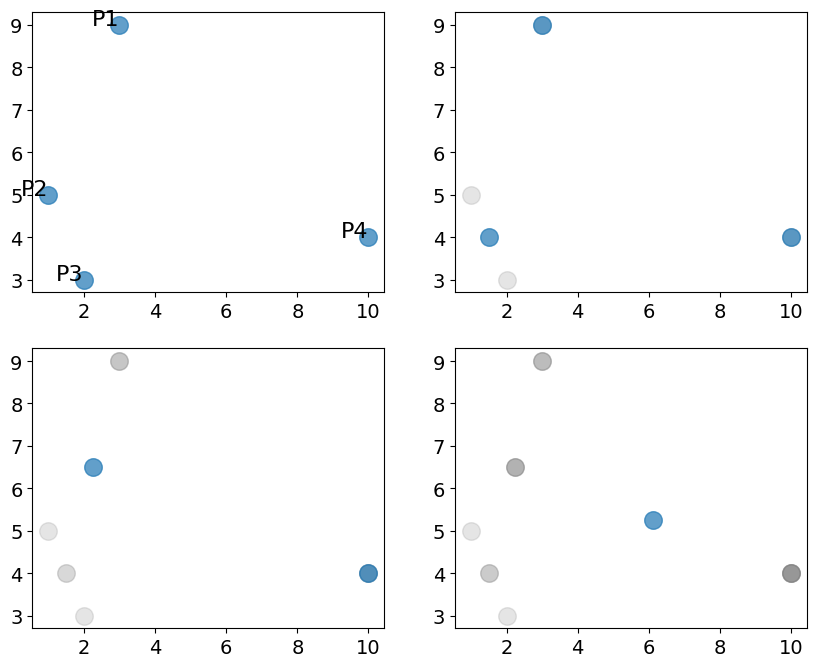

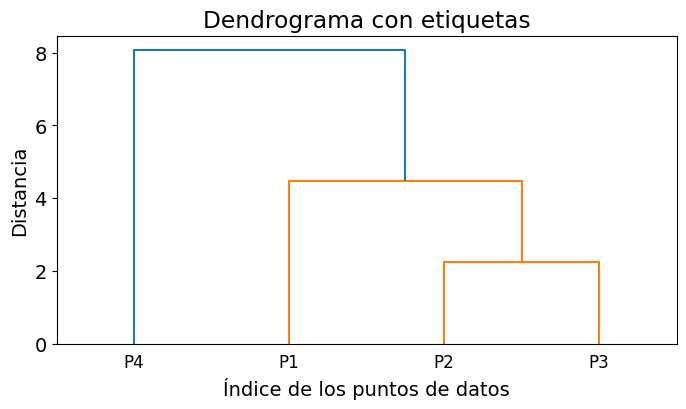

In [2]:
# Definir los puntos de datos
points = np.array([[3, 9], [1, 5], [2, 3], [10, 4]])

fig,axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.reshape(-1)
axs[0].scatter(points[:,0], points[:,1], alpha=0.7, s=160)
for i, txt in enumerate(['P1', 'P2', 'P3', 'P4']):
    axs[0].annotate(txt, (points[i, 0], points[i, 1]), fontsize=16, ha='right')
# Calcular el enlace aglomerativo
Z = linkage(points, 'single')

points1 = np.array([[3, 9], [1.5, 4], [10, 4]])
axs[1].scatter(points[:,0], points[:,1], alpha=0.2, s=160, color='C07')
axs[1].scatter(points1[:,0], points1[:,1], alpha=0.7, s=160)

points2 = np.array([[2.25, 6.5], [10, 4]])
axs[2].scatter(points[:,0], points[:,1], alpha=0.2, s=160, color='C07')
axs[2].scatter(points1[:,0], points1[:,1], alpha=0.3, s=160,color='C07')
axs[2].scatter(points2[:,0], points2[:,1], alpha=0.7, s=160)

points3 = np.array([[12.25/2.0, 10.5/2.0]])
axs[3].scatter(points[:,0], points[:,1], alpha=0.2, s=160, color='C07')
axs[3].scatter(points1[:,0], points1[:,1], alpha=0.4, s=160,color='C07')
axs[3].scatter(points2[:,0], points2[:,1], alpha=0.6, s=160,color='C07')
axs[3].scatter(points3[:,0], points3[:,1], alpha=0.7, s=160)


# # Crear el dendrograma
# dn = dendrogram(Z)

# # Obtener el orden de las hojas
# leaf_order = dn['leaves']
# print("Orden de las hojas:", leaf_order)

# Graficar el dendrograma con anotaciones en las hojas
plt.figure(figsize=(8, 4))
dendrogram(Z, labels=['P1', 'P2', 'P3', 'P4'])
plt.title('Dendrograma con etiquetas')
plt.xlabel('Índice de los puntos de datos')
plt.ylabel('Distancia')
plt.show()


In [ ]:
# Crear el dendrograma
dn = dendrogram(Z)

# Obtener el orden de las hojas
leaf_order = dn['leaves']
print("Orden de las hojas:", leaf_order)

# Graficar el dendrograma con anotaciones en las hojas
plt.figure(figsize=(8, 4))
dendrogram(Z, labels=['P1', 'P2', 'P3', 'P4'])
plt.title('Dendrograma con etiquetas')
plt.xlabel('Índice de los puntos de datos')
plt.ylabel('Distancia')
plt.show()


plt.bar(range(4),dn['leaves'], alpha=0.5)
plt.plot(np.array([0, 4]),np.array([1, 1]),'r:',linewidth=2, alpha=0.5)
plt.plot(np.array([1.5, 1.5]),np.array([0, 4]),'r:',linewidth=2, alpha=0.5)

plt.show()

### Ejemplo: Dendrograma.

In [14]:
# Training and testing set sizes
n1 = 100 # Train
n2 = 50  # Test

# Random ellipse 1 centered at (0,0)
x = np.random.randn(n1+n2)
y = 0.5*np.random.randn(n1+n2)

# Random ellipse 2 centered at (1,-2)
x2 = np.random.randn(n1+n2) + 1
y2 = 0.2*np.random.randn(n1+n2) - 2

# Rotate ellipse 2 by theta
theta = np.pi/4
A = np.zeros((2,2)); A[0,0] = np.cos(theta); A[0,1] = -np.sin(theta); A[1,0] = np.sin(theta); A[1,1] = np.cos(theta)

x3 = A[0,0]*x2 + A[0,1]*y2
y3 = A[1,0]*x2 + A[1,1]*y2

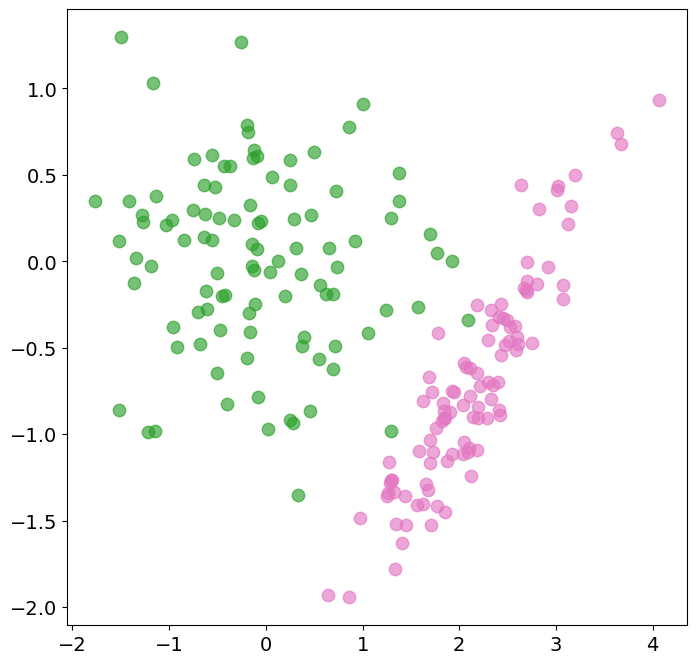

In [15]:
plt.figure()
plt.scatter(x[:n1],y[:n1],color='C02', alpha=0.65, s=80)
plt.scatter(x3[:n1],y3[:n1],color='C06', alpha=0.65, s=80)
plt.show()

In [16]:
# Training set: first 200 of 240 points
X1 = np.column_stack((x3[:n1],y3[:n1]))
X2 = np.column_stack((x[:n1],y[:n1]))

Y = np.concatenate((X1,X2))
Z = np.column_stack((np.ones(n1),2*np.ones(n1)))

# Test set: remaining 40 points
x1test = np.column_stack((x3[n1:],y3[n1:]))
x2test = np.column_stack((x[n1:],y[n1:]))

2.258664477296114


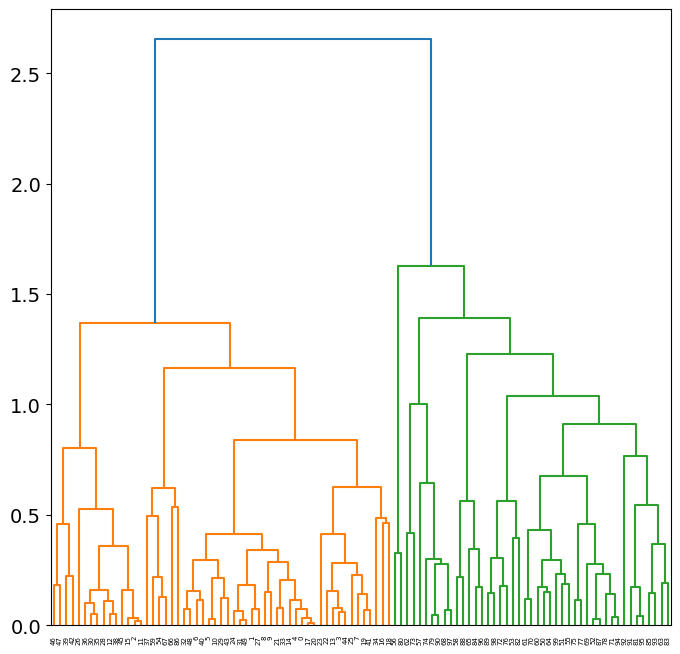

In [22]:
## Dendrograms
Y3 = np.concatenate((X1[:50,:],X2[:50,:]))
Y2 = pdist(Y3,metric='euclidean')
Z = hierarchy.linkage(Y2,method='average')
thresh = 0.85*np.max(Z[:,2])
print(thresh)
plt.figure()
dn = hierarchy.dendrogram(Z,p=100,color_threshold=thresh, no_labels=False)
# plt.axis('off')

plt.show()

Dendrograma generado a partir de los datos anteriores. El dendrograma muestra cuales puntos son fusionados como tambien la distancia entre los puntos. Dos clusters son generados para el nivel de umbral del 85\% de la distancia maxima de los puntos iniciales.

Recuerde que los primeros 50 puntos de datos son del primer cluster, mientras que los ultimos 50 son del segundo.

In [23]:
from scipy.cluster.hierarchy import fcluster 

# Assign each data point to a cluster based on the threshold 
clusters = fcluster(Z, thresh, criterion='distance') 

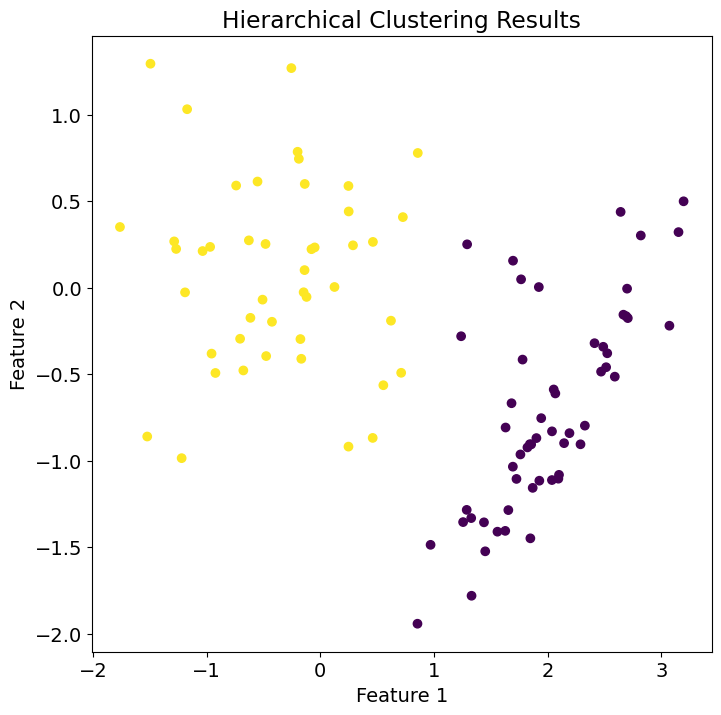

In [24]:
plt.scatter(Y3[:, 0], Y3[:, 1], c=clusters, cmap='viridis') 
plt.xlabel('Feature 1') 
plt.ylabel('Feature 2') 
plt.title('Hierarchical Clustering Results') 
plt.show() 


In [158]:
# plt.bar(range(100),dn['leaves'], alpha=0.5)
# plt.plot(np.array([0, 100]),np.array([50, 50]),'r:',linewidth=2, alpha=0.5)
# plt.plot(np.array([50.5, 50.5]),np.array([0, 100]),'r:',linewidth=2, alpha=0.5)

# plt.show()

<hr style="border:2px solid #03122E"> </hr>

La figura anterior muetra como los datos fueron clusterizados por el dendrograma. Si se alcanza el clustering perfecto los primeros 50 puntos estaria todos por debajo o por encima de la linea horizontal roja y lo opuesto para los ultimos 50 puntos.

## Aprendizaje Supervisado y Discriminantes Lineales

Unos de los primeros metodos de aprendizaje supervisado para la clasificacion de datos fue desarrollado por Fisher en 1936 en el contexto de taxonomia. Su Analisis de Discriminante Lineal (LDA) es aun una de las tecnicas estandar para clasificacion. Fue luego generalizado por C. R. Rao para datos multi-clases en 1948. El objetivo de estos algoritmos es encontrar una combinacion lineales de los atributos que caractericen o separen dos o mas clases de objetos or eventos en los datos. Notar que para esta tecnica supervisada tenemos los datos etiquetados lo que guia el algoritmo de clasificacion.

El algoritmo LDA busca resolver un problema de optimizacion para encontrar un subespacio donde los datos etiquetados tengan una clara sepracion entre la distribucion de sus puntos. Esto hace que la clasificacion sea mas facil porque un espacio  optimo de los atributos ha sido escogido.



El **objetivo del LDA** es encontrar una proyección adecuada que maximice la distancia entre los datos de diferentes clases mientras minimiza la distancia dentro de los datos de la misma clase.

Para un LDA de dos clases, resulta en la siguiente formulacion matematica. Construir una proyeccion $\mathbf{w}$ tal que:
$$
\mathbf{w} = \text{argmax}_{\mathbf{w}} \frac{\mathbf{w}^\top S_{B}\mathbf{w} }{\mathbf{w}^\top S_{W} \mathbf{w}}\quad(\text{cuociente de Rayleigh generalizado})
$$
Donde las matrices de dispersión para los datos entre clases $S_{B}$ y dentro de las clases $S_{W}$ se dan por
$$
S_{B} = (\mu_2-\mu_1)(\mu_2-\mu_1)^\top
$$

$$
S_{W} = \sum_{j=1}^{2} \sum_{\mathbf{x}\in \mathcal D_j} (\mathbf{x}-\mu_j)(\mathbf{x}-\mu_j)^\top
$$

Estas cantidades miden la varianza de los conjuntos de datos tanto como la varianza de la diferencia de las medias. La solucion del problema de minimizacion se puede encontrar mediante un problema de valores propios generalizado:
$$
S_{B} \mathbf{w} = \lambda S_{W}\mathbf{w}
$$

In [25]:
from scipy import io
import os
from mpl_toolkits import mplot3d
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

## Ejemplo de perros versus gatos

**Imagenes Raw**

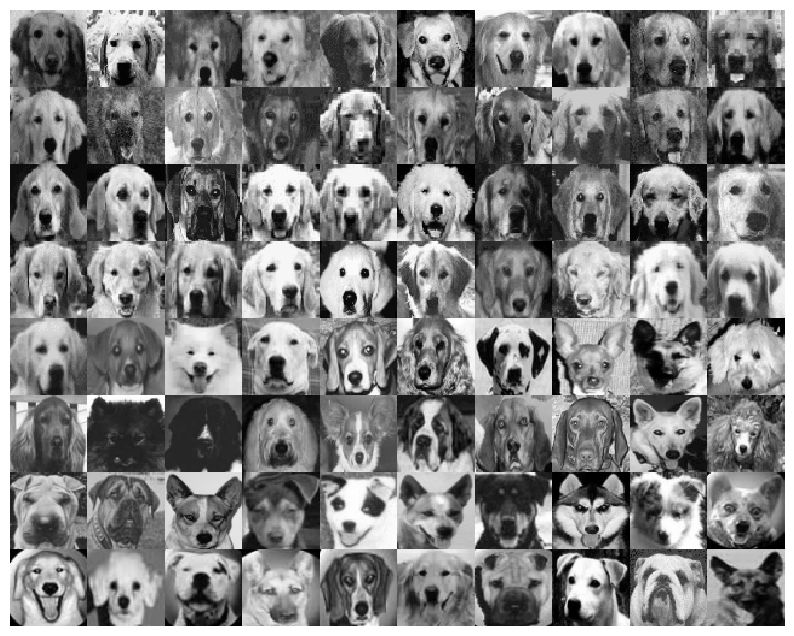

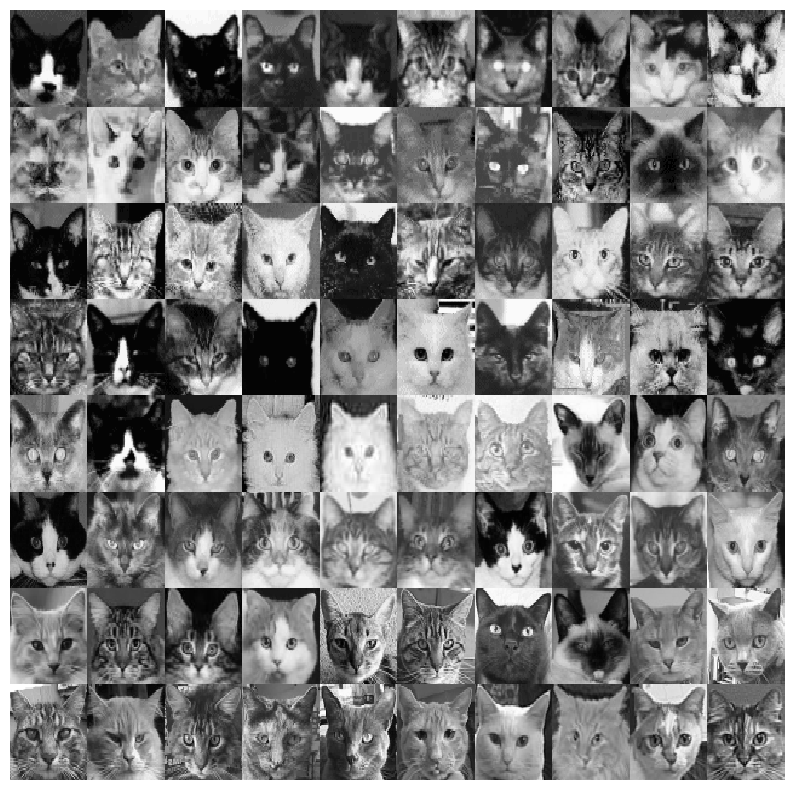

In [26]:
dogdata_mat = io.loadmat('dogData.mat')
catdata_mat = io.loadmat('catData.mat')

dog = dogdata_mat['dog']
cat = catdata_mat['cat']

master_dog = np.zeros((64*10,64*8))
count = 0

fig, ax = plt.subplots(1,1,figsize=(10,8))
for jj in range(8):
    for j in range(10):
        T2 = np.flipud(np.reshape(dog[:,count],(64,64)))
        master_dog[64*j:64*(j+1),64*jj:64*(jj+1)] = T2
        count += 1

ax.pcolor(np.rot90(master_dog),cmap='gray')
ax.axis('off')

master_cat = np.zeros((64*10,64*8))
count = 0

fig, ax = plt.subplots(1,1,figsize=(10,10))
for jj in range(8):
    for j in range(10):
        T2 = np.flipud(np.reshape(cat[:,count],(64,64)))
        master_cat[64*j:64*(j+1),64*jj:64*(jj+1)] = T2
        count += 1

ax.pcolor(np.rot90(master_cat),cmap='gray')
ax.axis('off')
plt.show()

**Imagenes Wavelet**

(1024, 80)


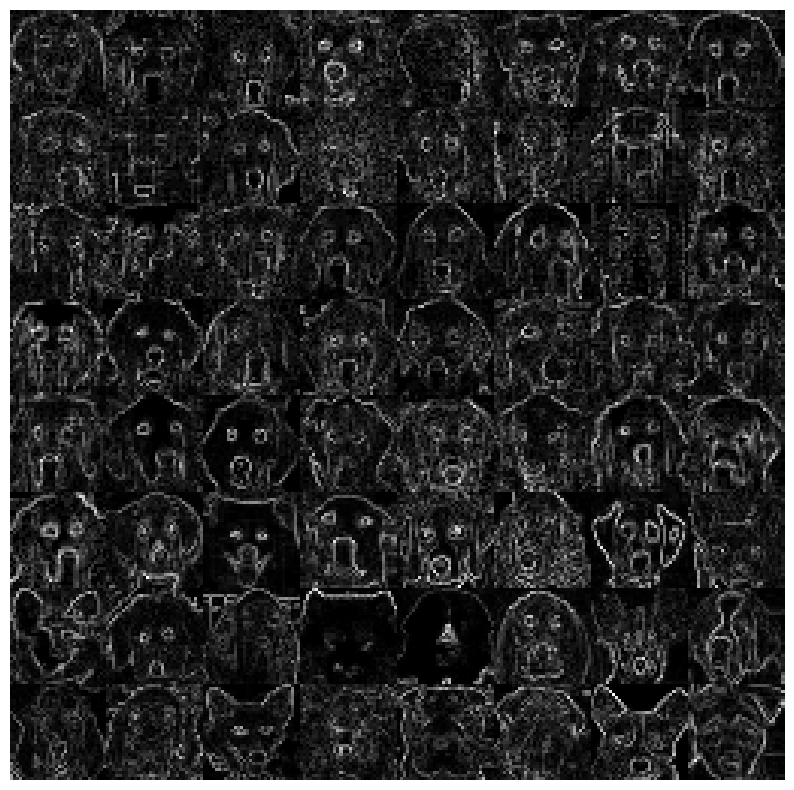

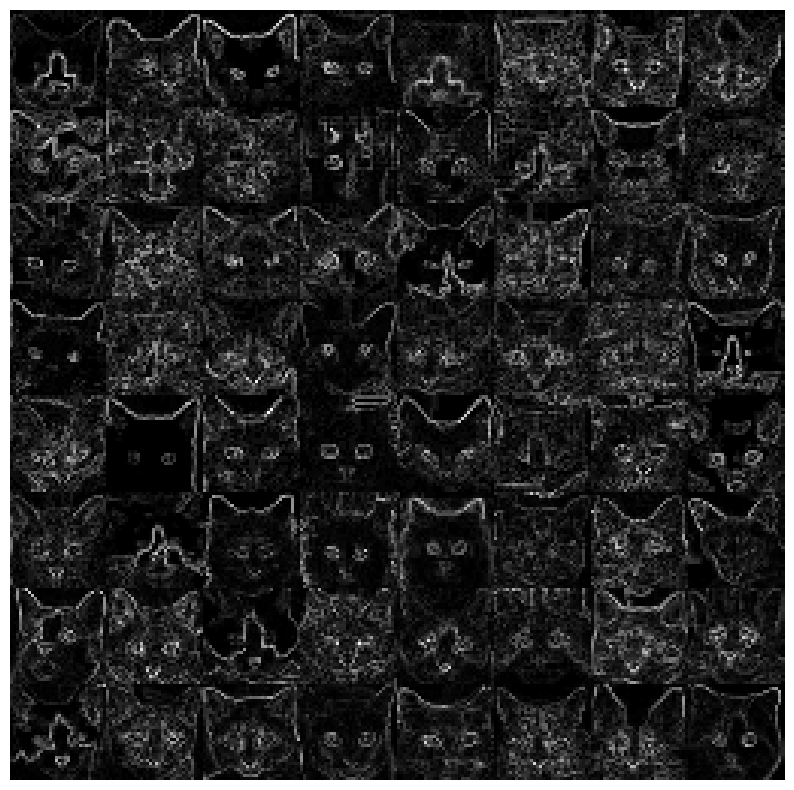

In [224]:
dogdata_w_mat = io.loadmat('dogData_w.mat')
catdata_w_mat = io.loadmat('catData_w.mat')

dog_wave = dogdata_w_mat['dog_wave']
cat_wave = catdata_w_mat['cat_wave']

print(dog_wave.shape)
master_dog = np.zeros((32*8,32*8))
count = 0

fig, ax = plt.subplots(1,1,figsize=(10,10))
for jj in range(8):
    for j in range(8):
        T2 = np.flipud(np.reshape(dog_wave[:,count],(32,32)))
        # T = T2[::2,::2]
        master_dog[32*j:32*(j+1),32*jj:32*(jj+1)] = T2
        count += 1

ax.pcolor(np.rot90(master_dog),cmap='gray')
ax.axis('off')

master_cat = np.zeros((32*8,32*8))
count = 0

fig, ax = plt.subplots(1,1,figsize=(10,10))
for jj in range(8):
    for j in range(8):
        T2 = np.flipud(np.reshape(cat_wave[:,count],(32,32)))
        # T = T2[::2,::2]
        master_cat[32*j:32*(j+1),32*jj:32*(jj+1)] = T2
        count += 1

ax.pcolor(np.rot90(master_cat),cmap='gray')
ax.axis('off')
plt.show()

In [238]:
CD = np.concatenate((dog,cat),axis=1)
CDw = np.concatenate((dog_wave,cat_wave),axis=1)

u,s,vT = np.linalg.svd(CD-np.mean(CD),full_matrices=0)
uw,sw,vTw = np.linalg.svd(CDw-np.mean(CDw),full_matrices=0)
vw = vTw.T

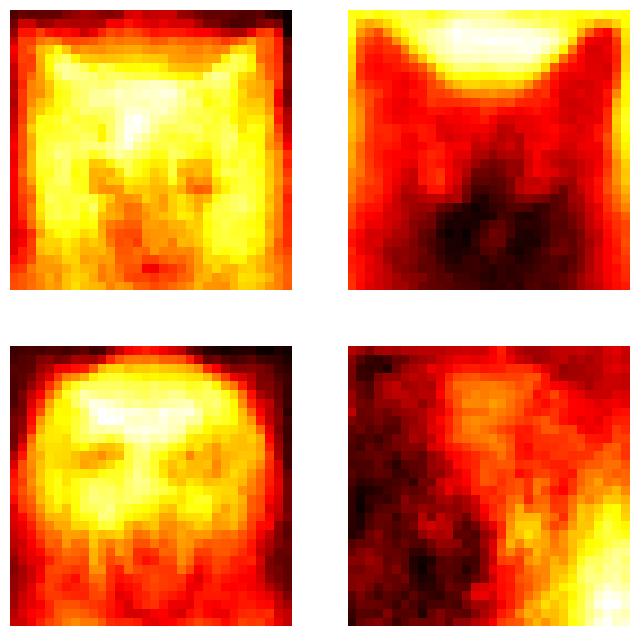

In [239]:
fig,axs = plt.subplots(2,2, figsize=(8,8))
axs = axs.reshape(-1)
for j in range(4):
    U = np.flipud(np.reshape(u[:,j],(64,64)))
    U2 = U[::2,::2]
    axs[j].pcolor(np.rot90(U2),cmap='hot')
    axs[j].axis('off')
plt.show()

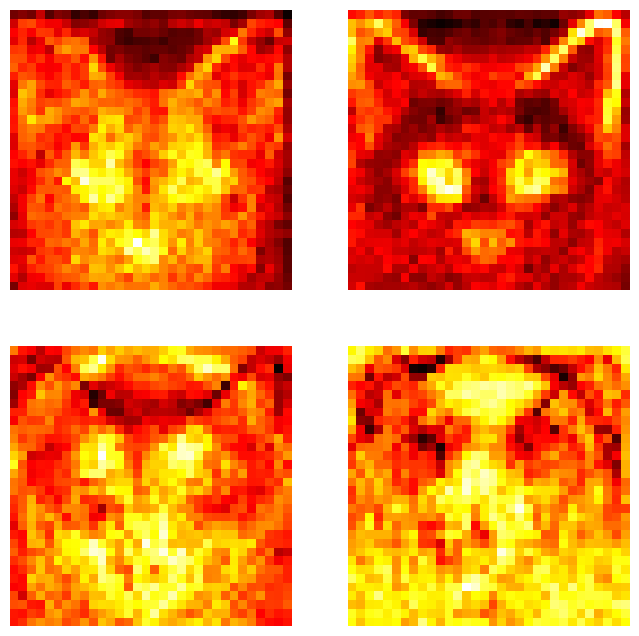

In [236]:
fig,axs = plt.subplots(2,2, figsize=(8,8))
axs = axs.reshape(-1)
for j in range(4):
    U3 = np.flipud(np.reshape(uw[:,j],(32,32)))
    axs[j].pcolor(np.rot90(U3),cmap='hot')
    axs[j].axis('off')
plt.show()

### Database images in the wavelet domain

In [265]:
xtrain_w = np.concatenate((vw[:60,np.array([1,3])],vw[80:140,np.array([1,3])]))
label = np.repeat(np.array([1,-1]),60)
test_w = np.concatenate((vw[60:80,np.array([1,3])],vw[140:160,np.array([1,3])]))

### LDA analysis of dogs vs. cats
Entrenamos 60 imagenes de perros y gatos, y luego testeamos el clasificador sobre los 20 imagenes de perrros y gatos restantes. Por simplicidad entrenamos sobre la segunda y la cuarta componenete prinicpal, ya que estos muestran buena discriminacion entre perros y gatos.

In [266]:
lda = LinearDiscriminantAnalysis()
test_class = lda.fit(xtrain_w, label).predict(test_w)

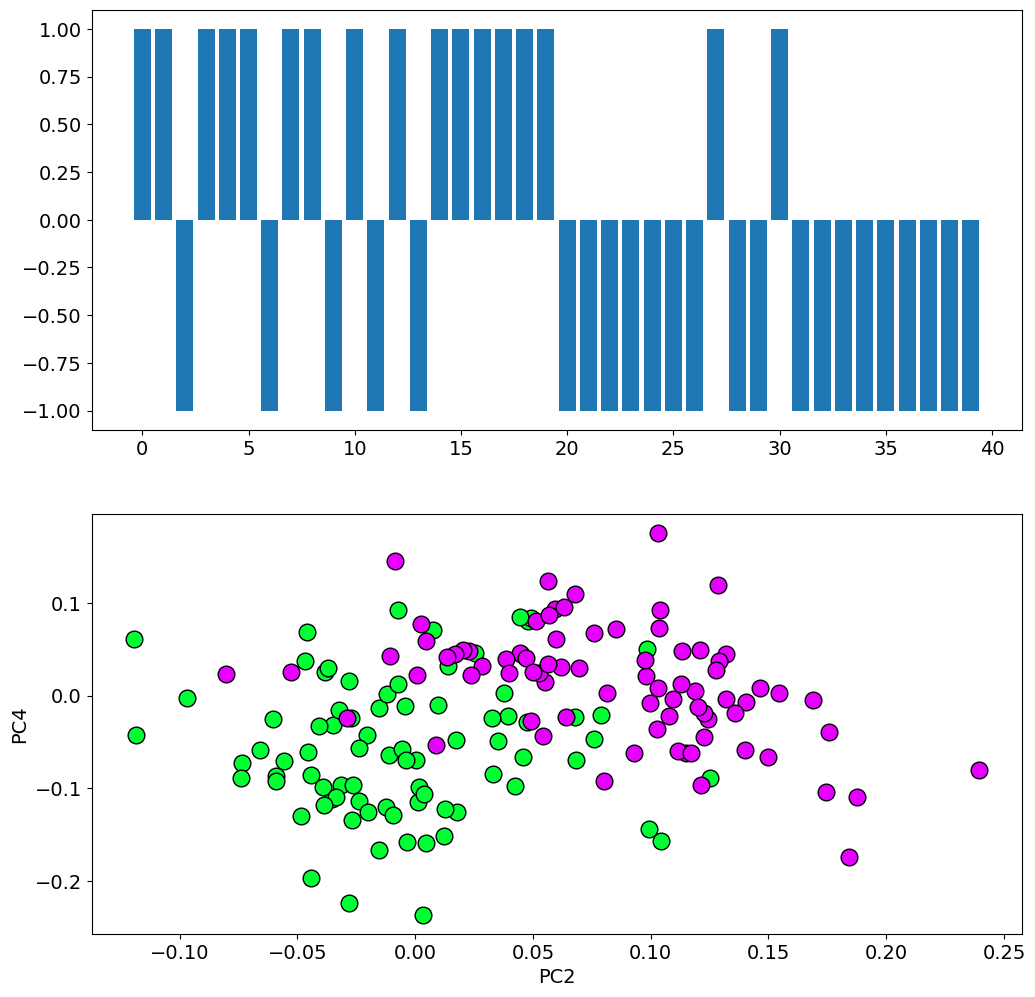

In [267]:
truth = np.repeat(np.array([1,-1]),20)
E = 100*(1-np.sum(0.5*np.abs(test_class - truth))/40)

fig,axs = plt.subplots(2)
axs[0].bar(range(40),test_class)

axs[1].plot(vw[:80,1],vw[:80,3],'ro',markerfacecolor=(0,1,0.2),markeredgecolor='k',ms=12)
axs[1].plot(vw[80:,1],vw[80:,3],'bo',markerfacecolor=(0.9,0,1),markeredgecolor='k',ms=12)
axs[1].set_ylabel('PC4')
axs[1].set_xlabel('PC2')

plt.show()

### LDA analisis con raw data

<ipython-input-251-a497c1e6c8af>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  axs[1].plot(v[:80,1],v[:80,3],'ro',MarkerFaceColor=(0,1,0.2),MarkerEdgeColor='k',ms=12)
<ipython-input-251-a497c1e6c8af>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  axs[1].plot(v[80:,1],v[80:,3],'bo',MarkerFaceColor=(0.9,0,1),MarkerEdgeColor='k',ms=12)


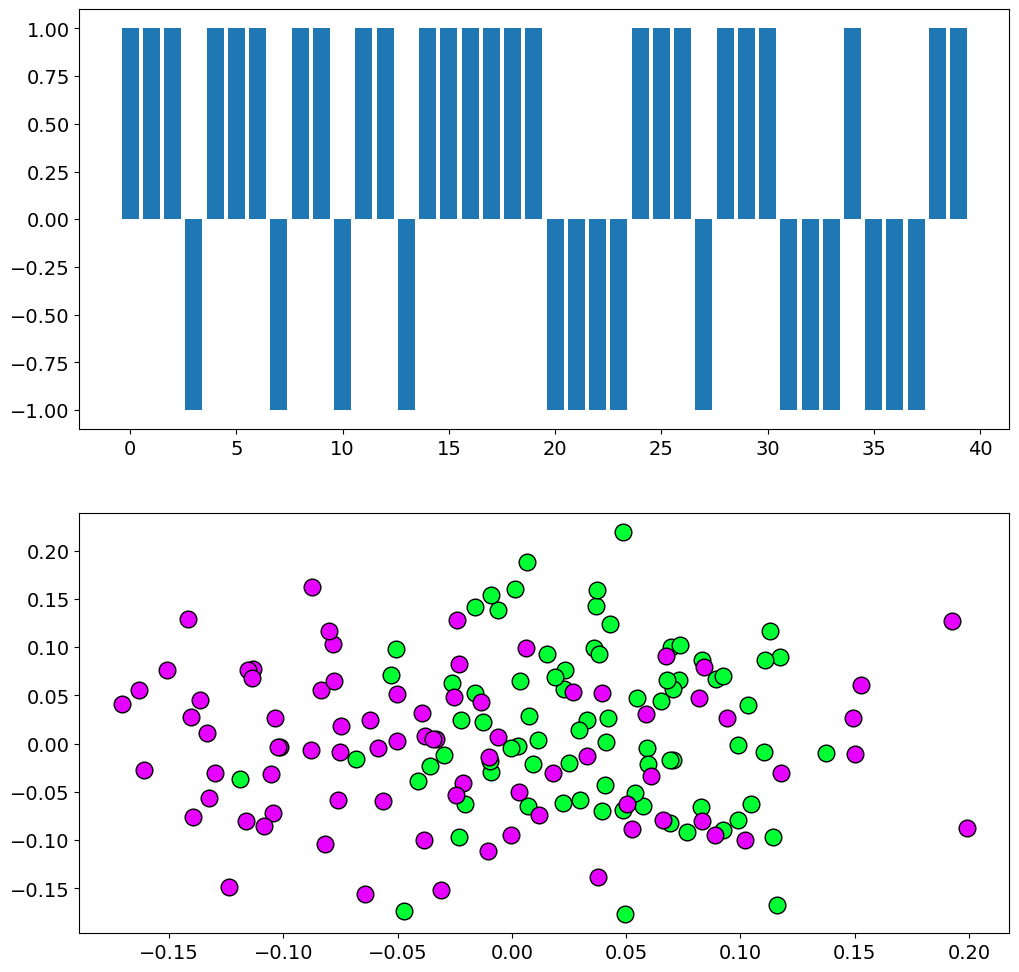

In [251]:
u,s,vT = np.linalg.svd(CD-np.mean(CD),full_matrices=0)
v = vT.T

plt.rcParams['figure.figsize'] = [12, 12]
xtrain = np.concatenate((v[:60,np.array([1,3])],v[80:140,np.array([1,3])]))
label = np.repeat(np.array([1,-1]),60)
test = np.concatenate((v[60:80,np.array([1,3])],v[140:160,np.array([1,3])]))

lda = LinearDiscriminantAnalysis()
test_class = lda.fit(xtrain, label).predict(test)

fig,axs = plt.subplots(2)
axs[0].bar(range(40),test_class)

axs[1].plot(v[:80,1],v[:80,3],'ro',MarkerFaceColor=(0,1,0.2),MarkerEdgeColor='k',ms=12)
axs[1].plot(v[80:,1],v[80:,3],'bo',MarkerFaceColor=(0.9,0,1),MarkerEdgeColor='k',ms=12)

plt.show()

### Cross Validations

Hacemos validacion cruzada con 100 experimentos

<ipython-input-270-98c8288ea405>:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(range(100),np.mean(E)*np.ones(100),'r:',LineWidth=3)


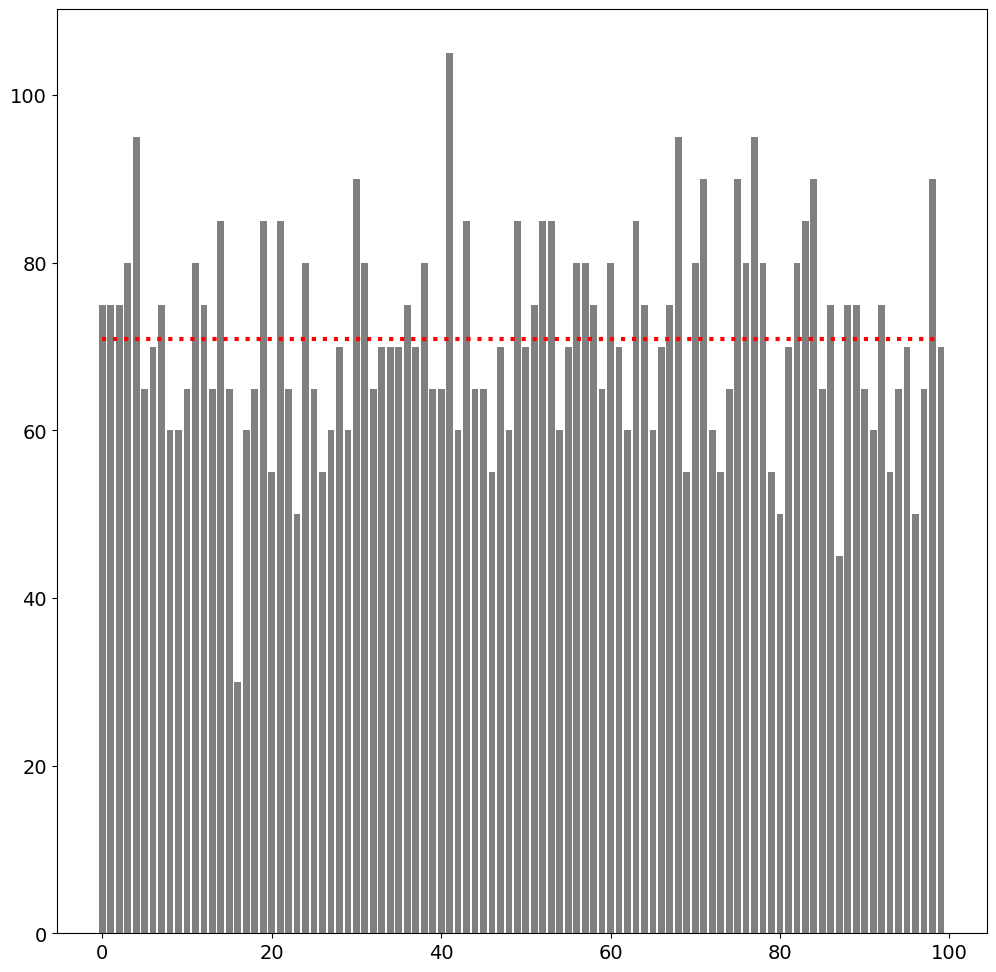

In [270]:

u,s,vT = np.linalg.svd(CD-np.mean(CD),full_matrices=0)
v = vT.T
## Cross-validate
E = np.zeros(100)

for jj in range(100):
    r1 = np.random.permutation(80)
    r2 = np.random.permutation(80)
    ind1 = r1[:60]
    ind2 = r2[:60]+60
    ind1t = r1[60:80]
    ind2t = r2[60:80]+60
    
    xtrain = np.concatenate((v[ind1[:, np.newaxis],np.array([1,3])], v[ind2[:, np.newaxis],np.array([1,3])]))
    test = np.concatenate((v[ind1t[:, np.newaxis],np.array([1,3])], v[ind2t[:, np.newaxis],np.array([1,3])]))
    
    label = np.repeat(np.array([1,-1]),60)

    lda = LinearDiscriminantAnalysis()
    test_class = lda.fit(xtrain, label).predict(test)

    truth = np.repeat(np.array([1,-1]),20)
    E[jj] = 100*np.sum(np.abs(test_class-truth))/40
    
plt.bar(range(100),E,color=(0.5,0.5,0.5))
plt.plot(range(100),np.mean(E)*np.ones(100),'r:',LineWidth=3)
plt.show()

In [17]:
CD = np.concatenate((dog_wave,cat_wave),axis=1)

u,s,vT = np.linalg.svd(CD-np.mean(CD),full_matrices=0)
v = vT.T

dog_wave = dogdata_w_mat['dog_wave']
cat_wave = catdata_w_mat['cat_wave']

plt.rcParams['figure.figsize'] = [12, 6]
fig,axs = plt.subplots(1,2)
for j in range(2):
    axs[j].plot(v[:80,1],v[:80,3],'ro',markerfacecolor=(0,1,0.2),markeredgecolor='k',ms=12)
    axs[j].plot(v[80:,1],v[80:,3],'bo',markerfacecolor=(0.9,0,1),markeredgecolor='k',ms=12)

# Linear Discriminant
xtrain = np.concatenate((v[:60,np.array([1,3])],v[80:140,np.array([1,3])]))
test = np.concatenate((v[60:80,np.array([1,3])],v[140:160,np.array([1,3])]))
label = np.repeat(np.array([1,-1]),60)



lda = LinearDiscriminantAnalysis().fit(xtrain, label)
test_class = lda.predict(test)
K = -lda.intercept_[0]
L = -lda.coef_[0]


x = np.arange(-0.15,0.25,0.005)
axs[0].plot(x,-(L[0]*x+K)/L[1],'k',linewidth=2)


# Quadratic Discriminant
qda = QuadraticDiscriminantAnalysis().fit(xtrain, label)
y = np.arange(-0.3,0.25,0.001)
X,Y = np.meshgrid(x,y)

Z = np.zeros_like(X)

for jj in range(len(x)):
    for kk in range(len(y)):
        Z[kk,jj] = qda.predict(np.array([[x[jj],y[kk]]]))

axs[1].contour(X,Y,Z,0,colors='k',linewidths=2)        

plt.show()

NameError: name 'dog_wave' is not defined

<hr style="border:2px solid #03122E"> </hr>

## Arboles de decision
Classification trees (Arboles de clasificación, supervised learning)

\begin{align}
&\text{data } \quad \{x_j\in R^{n}, \;j\in Z := \{1,2,...,m\} \} \\
&\text{labels }\quad \{y_j \in\{\pm 1\}, j\in Z' \subset Z\}
\end{align}
Analizar sobre las $n$-componentes de los datos. Si solo miramos la componente 1 y la asociamos con las etiquetas podemos decidir una clasificacion respecto a esta. Hacemos esto con cada componente.

**Iris dataset**

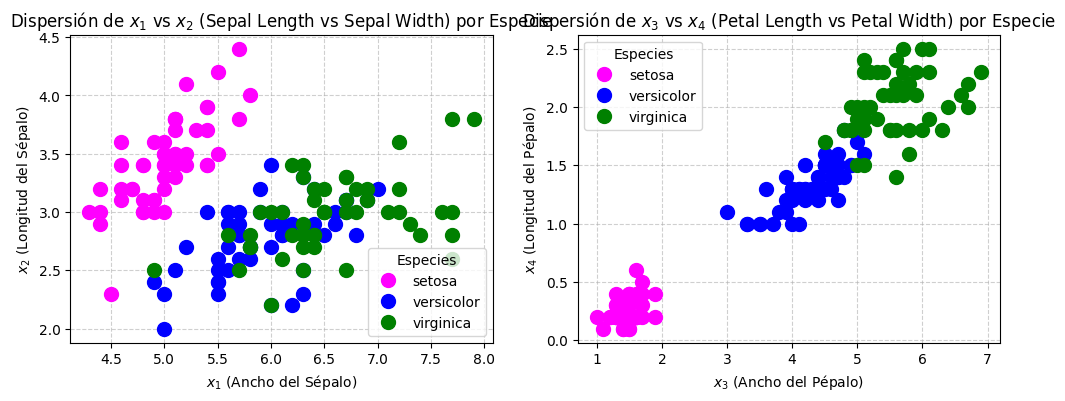

In [27]:
import numpy as np
import pandas as pd
import scipy.io as io
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import cross_val_score
import six
import pydotplus
from IPython.display import Image 
import matplotlib.pyplot as plt

# --- Data Loading and Preprocessing ---
fisheriris_mat = io.loadmat('fisheriris.mat')
meas = fisheriris_mat['meas']
x1 = meas[:,0]
x2 = meas[:,1]
x3 = meas[:,2]
x4 = meas[:,3]
species_raw = fisheriris_mat['species'] 


# Limpiamos y aplanamos el vector de especies para obtener una lista simple de strings
# La limpieza es crucial para asegurar que tengamos 'setosa', 'versicolor' y 'virginica'
species = [s[0][0][:] for s in species_raw]
# Creamos un DataFrame para graficar más fácilmente
df = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4,
    'Especie': species
})

# --- 2. Generación del Gráfico de Dispersión Coloreado ---
plt.rcParams['figure.figsize'] = [12,4]
fig, ax = plt.subplots(1,2)

# Obtenemos las tres especies únicas
unique_species = df['Especie'].unique()

# Definimos 3 colores distintos
colors = ['magenta', 'blue', 'green']
color_map = dict(zip(unique_species, colors))

for name, group in df.groupby('Especie'):
    ax[0].plot(
        group['x1'],           # Valores de x1 para la especie actual
        group['x2'],           # Valores de x2 para la especie actual
        marker='o',            # Usar círculos
        linestyle='',          # No conectar los puntos
        color=color_map[name], # El color asignado
        ms=10,                 # Tamaño del marcador
        label=name             # Etiqueta para la leyenda
    )

    ax[1].plot(
        group['x3'],           # Valores de x3 para la especie actual
        group['x4'],           # Valores de x4 para la especie actual
        marker='o',            # Usar círculos
        linestyle='',          # No conectar los puntos
        color=color_map[name], # El color asignado
        ms=10,                 # Tamaño del marcador
        label=name             # Etiqueta para la leyenda
    )
ax[0].set_title('Dispersión de $x_1$ vs $x_2$ (Sepal Length vs Sepal Width) por Especie')
ax[0].set_xlabel('$x_1$ (Ancho del Sépalo)')
ax[0].set_ylabel('$x_2$ (Longitud del Sépalo)')
ax[0].legend(title='Especies')
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].set_title('Dispersión de $x_3$ vs $x_4$ (Petal Length vs Petal Width) por Especie')
ax[1].set_xlabel('$x_3$ (Ancho del Pépalo)')
ax[1].set_ylabel('$x_4$ (Longitud del Pépalo)')
ax[1].legend(title='Especies')
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.show()

In [28]:
# The Fix: Flatten and convert to a list of strings
species_flat_list = species_raw.ravel().tolist() 

le = preprocessing.LabelEncoder()

# # The warning persists, but the code successfully processes the data
le.fit(np.array(species_flat_list).ravel())
species_label = np.array(species_flat_list).ravel()# le.transform(species_flat_list) 
# print(type(species_label))
# print(type(meas))

# --- Model Training and Evaluation (Remaining code) ---
decision_tree = tree.DecisionTreeClassifier(max_depth=3).fit(meas, species_label.ravel())

# Visualization code (omitted for brevity, but it is correct)
dot_data = six.StringIO()
tree.export_graphviz(decision_tree, out_file=dot_data,  
                     feature_names=['sepal width', 'sepal length', 'petal width', 'petal length'],
                     class_names=le.classes_, 
                     filled=True, rounded=True,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_png('arbol_de_decision.png')

cv = cross_val_score(decision_tree, meas, species_label, cv=10)
classError = 1 - np.mean(cv)

print(f"Average Accuracy: {np.mean(cv):.4f}")
print(f"Classification Error: {classError:.4f}")

Average Accuracy: 0.9600
Classification Error: 0.0400


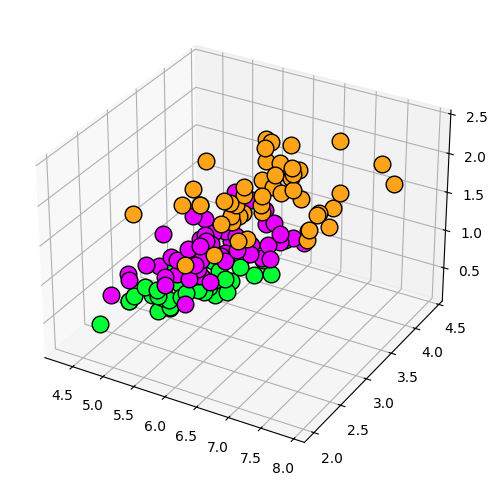

In [31]:
x1 = meas[:50,:]     # setosa
x2 = meas[50:100,:]  # versicolor
x3 = meas[100:150,:] # virginica

plt.rcParams['figure.figsize'] = [8,6]

fig = plt.figure()
ax = plt.subplot(111,projection='3d')
ax.plot(x1[:,0],x1[:,1],x1[:,3],'o',markerfacecolor=(0,1,0.2),markeredgecolor='k',ms=12)
ax.plot(x2[:,0],x2[:,1],x2[:,3],'o',markerfacecolor=(0.9,0,1),markeredgecolor='k',ms=12)
ax.plot(x3[:,0],x3[:,1],x3[:,3],'o',markerfacecolor=(1,0.64,0.098),markeredgecolor='k',ms=12)

plt.show()

In [32]:
# dogs vs. cats
dogdata_w_mat = io.loadmat(os.path.join('..','DATA','dogData_w.mat'))
catdata_w_mat = io.loadmat(os.path.join('..','DATA','catData_w.mat'))

dog_wave = dogdata_w_mat['dog_wave']
cat_wave = catdata_w_mat['cat_wave']

CD = np.concatenate((dog_wave,cat_wave),axis=1)

u,s,vT = np.linalg.svd(CD-np.mean(CD),full_matrices=0)
v = vT.T

features = np.arange(1,21)
xtrain = np.concatenate((v[:60,features],v[80:140,features]))
test = np.concatenate((v[60:80,features],v[140:160,features]))

label = np.repeat(np.array([1,-1]),60)
truth = np.repeat(np.array([1,-1]),20)

Mdl = tree.DecisionTreeClassifier(max_depth=2).fit(xtrain,label)
cv = cross_val_score(Mdl, xtrain, label, cv=10) #cross-validate the model
classError = 1-np.mean(cv) # average error over all cross-validation iterations

dot_data = StringIO()

tree.export_graphviz(Mdl, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NameError: name 'os' is not defined